In [1]:
import os
import re
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# NLP библиотеки
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0
import textstat
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy import stats
import spacy

# Загрузка моделей и ресурсов NLTK
nltk.download('punkt')
nltk.download('stopwords')

# Инициализация spaCy модели (для русского и английского)
try:
    nlp_ru = spacy.load('ru_core_news_sm')
except:
    os.system('python -m spacy download ru_core_news_sm')
    nlp_ru = spacy.load('ru_core_news_sm')

try:
    nlp_en = spacy.load('en_core_web_sm')
except:
    os.system('python -m spacy download en_core_web_sm')
    nlp_en = spacy.load('en_core_web_sm')

# Установка путей
DATA_DIR = Path('data')
BOOKS_DIR = DATA_DIR / 'books'

# Урбанистические термины для анализа (можно расширить)
URBAN_TERMS = [
    'город', 'урбанизм', 'пространство', 'инфраструктура', 'транспорт',
    'жилье', 'экология', 'сообщество', 'планирование', 'архитектура',
    'джентрификация', 'субурбанизация', 'мегаполис', 'агломерация'
]

# Авторы для отслеживания
AUTHORS = [
    'джейн джекобс', 'джейн джейкобс', 'jacobs', 'джейн',
    'хаузер', 'ле корбюзье', 'корбюзье', 'линч', 'гейл'
]

[nltk_data] Downloading package punkt to /home/artem/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/artem/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 29.6 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 55.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [ru-core-news-sm] [ru-core-news-sm]
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 62.7 MB/s  0:00:00 eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
def extract_text_from_pdf(pdf_path):
    """
    Извлечение текста из PDF файла
    """
    try:
        import PyPDF2

        text = ""
        with open(pdf_path, 'rb') as file:
            pdf_reader = PyPDF2.PdfReader(file)
            for page in pdf_reader.pages:
                text += page.extract_text() + "\n"
        return text.strip()
    except Exception as e:
        print(f"Ошибка при чтении {pdf_path}: {e}")
        return ""

def load_course_materials():
    """
    Загрузка всех материалов курса из PDF файлов
    """
    materials = []
    file_info = []

    if not BOOKS_DIR.exists():
        print(f"Директория {BOOKS_DIR} не найдена!")
        return [], []

    pdf_files = list(BOOKS_DIR.glob('*.pdf'))
    print(f"Найдено PDF файлов: {len(pdf_files)}")

    for pdf_file in pdf_files:
        text = extract_text_from_pdf(pdf_file)
        if text:
            materials.append({
                'filename': pdf_file.name,
                'text': text,
                'length_chars': len(text),
                'length_words': len(text.split())
            })
            file_info.append(pdf_file.name)

    print(f"Загружено материалов: {len(materials)}")
    return materials, file_info

# Загрузка данных
materials, file_names = load_course_materials()

# Создание DataFrame для анализа
df = pd.DataFrame(materials) if materials else pd.DataFrame()

Найдено PDF файлов: 9
Загружено материалов: 9


ВИЗУАЛИЗАЦИИ ДАННЫХ


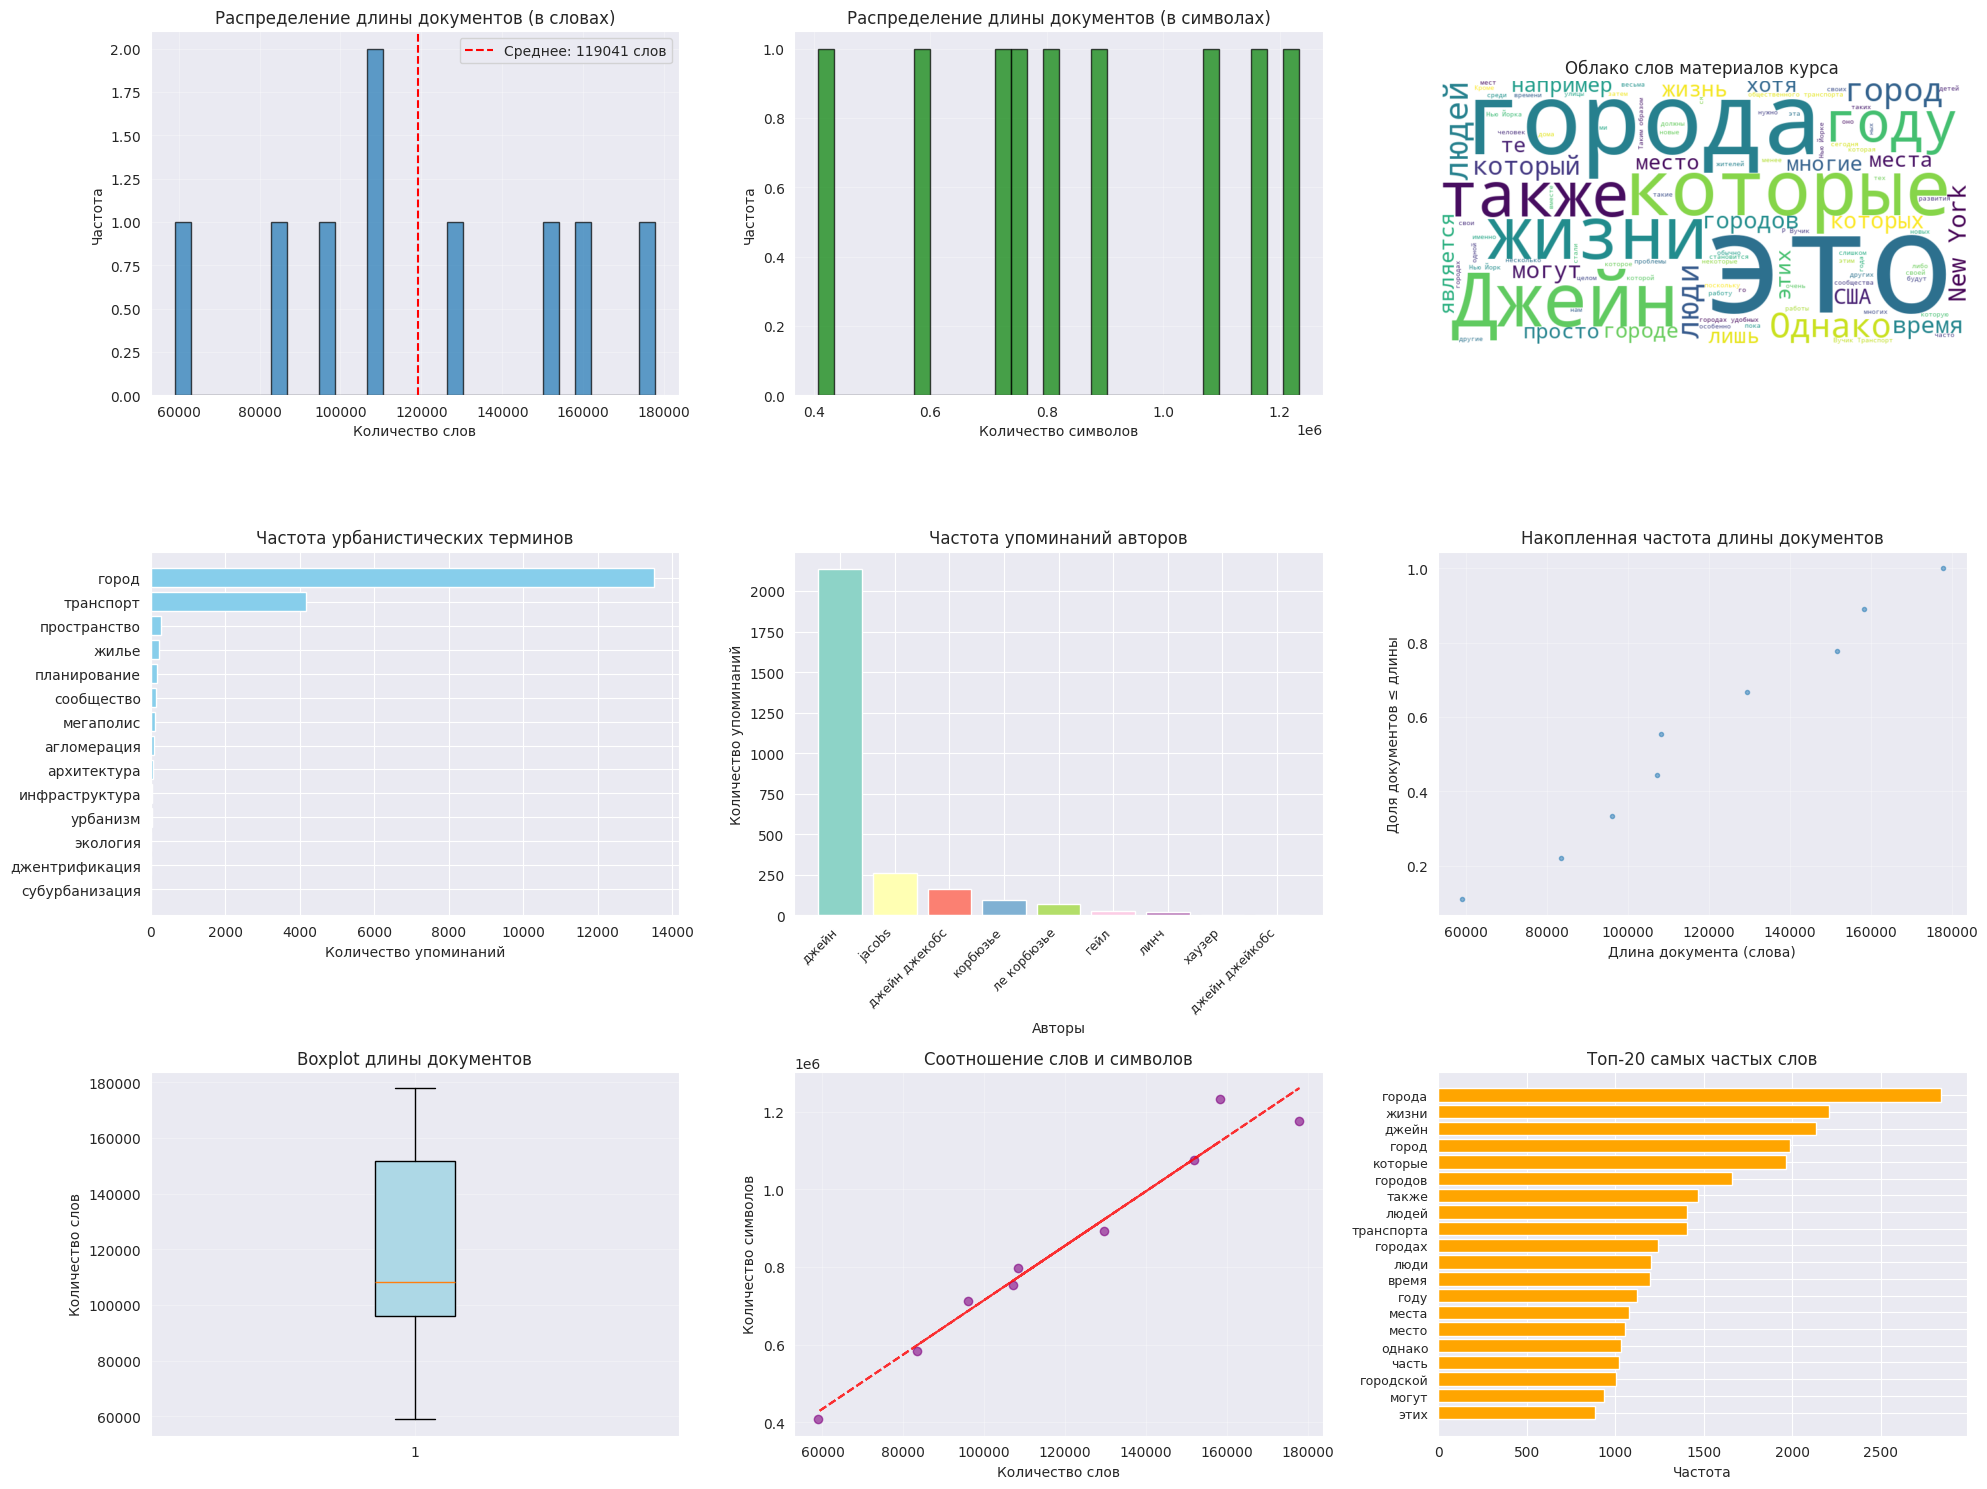


СТАТИСТИКА ДОКУМЕНТОВ:
Средняя длина документа: 119041 слов
Медианная длина: 108228 слов
Минимальная длина: 58987 слов
Максимальная длина: 177791 слов
Стандартное отклонение: 38464 слов

САМЫЕ ЧАСТЫЕ УРБАНИСТИЧЕСКИЕ ТЕРМИНЫ:
  город: 13514 упоминаний
  транспорт: 4175 упоминаний
  пространство: 270 упоминаний
  жилье: 230 упоминаний
  планирование: 169 упоминаний

САМЫЕ ЧАСТО УПОМИНАЕМЫЕ АВТОРЫ:
  джейн: 2136 упоминаний
  jacobs: 263 упоминаний
  джейн джекобс: 163 упоминаний
  корбюзье: 97 упоминаний
  ле корбюзье: 71 упоминаний


In [6]:
def create_visualizations(df):
    """
    Создание визуализаций для анализа материалов курса
    """
    print("=" * 50)
    print("ВИЗУАЛИЗАЦИИ ДАННЫХ")
    print("=" * 50)

    if df.empty:
        print("Нет данных для визуализации")
        return

    # Создаем фигуру с несколькими графиками
    fig = plt.figure(figsize=(20, 15))

    # 1. Гистограмма длины документов (в словах)
    ax1 = plt.subplot(3, 3, 1)
    ax1.hist(df['length_words'], bins=30, edgecolor='black', alpha=0.7)
    ax1.set_title('Распределение длины документов (в словах)', fontsize=12)
    ax1.set_xlabel('Количество слов')
    ax1.set_ylabel('Частота')
    ax1.grid(True, alpha=0.3)

    # Добавляем вертикальную линию для среднего
    mean_words = df['length_words'].mean()
    ax1.axvline(mean_words, color='red', linestyle='--',
                label=f'Среднее: {mean_words:.0f} слов')
    ax1.legend()

    # 2. Гистограмма длины документов (в символах)
    ax2 = plt.subplot(3, 3, 2)
    ax2.hist(df['length_chars'], bins=30, edgecolor='black', alpha=0.7, color='green')
    ax2.set_title('Распределение длины документов (в символах)', fontsize=12)
    ax2.set_xlabel('Количество символов')
    ax2.set_ylabel('Частота')
    ax2.grid(True, alpha=0.3)

    # 3. Облако слов для всех материалов
    ax3 = plt.subplot(3, 3, 3)

    # Объединяем все тексты
    all_text = ' '.join(df['text'].tolist())

    # Очищаем текст для облака слов
    # Удаляем стоп-слова и короткие слова
    stop_words_ru = set(stopwords.words('russian'))
    stop_words_en = set(stopwords.words('english'))
    all_stop_words = stop_words_ru.union(stop_words_en)

    # Создаем облако слов
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=all_stop_words,
        max_words=100,
        colormap='viridis'
    ).generate(all_text)

    ax3.imshow(wordcloud, interpolation='bilinear')
    ax3.set_title('Облако слов материалов курса', fontsize=12)
    ax3.axis('off')

    # 4. Распределение ключевых терминов урбанистики
    ax4 = plt.subplot(3, 3, 4)

    # Подсчет частоты урбанистических терминов
    urban_term_freq = {}
    for term in URBAN_TERMS:
        count = 0
        for text in df['text']:
            # Ищем термин в тексте (регистронезависимо)
            count += len(re.findall(term.lower(), text.lower()))
        urban_term_freq[term] = count

    # Сортируем по частоте
    sorted_terms = sorted(urban_term_freq.items(), key=lambda x: x[1], reverse=True)
    terms, frequencies = zip(*sorted_terms)

    ax4.barh(range(len(terms)), frequencies, color='skyblue')
    ax4.set_yticks(range(len(terms)))
    ax4.set_yticklabels(terms, fontsize=10)
    ax4.set_title('Частота урбанистических терминов', fontsize=12)
    ax4.set_xlabel('Количество упоминаний')
    ax4.invert_yaxis()

    # 5. Частота упоминаний авторов
    ax5 = plt.subplot(3, 3, 5)

    author_freq = {}
    for author in AUTHORS:
        count = 0
        for text in df['text']:
            count += len(re.findall(author.lower(), text.lower()))
        author_freq[author] = count

    # Сортируем по частоте
    sorted_authors = sorted(author_freq.items(), key=lambda x: x[1], reverse=True)
    authors, author_counts = zip(*sorted_authors)

    colors = plt.cm.Set3(np.linspace(0, 1, len(authors)))
    bars = ax5.bar(range(len(authors)), author_counts, color=colors)
    ax5.set_title('Частота упоминаний авторов', fontsize=12)
    ax5.set_xlabel('Авторы')
    ax5.set_ylabel('Количество упоминаний')
    ax5.set_xticks(range(len(authors)))
    ax5.set_xticklabels(authors, rotation=45, ha='right', fontsize=9)

    # 6. График с накопленной частотой длины документов
    ax6 = plt.subplot(3, 3, 6)

    sorted_lengths = np.sort(df['length_words'])
    cumulative = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths)

    ax6.plot(sorted_lengths, cumulative, marker='.', linestyle='none', alpha=0.5)
    ax6.set_title('Накопленная частота длины документов', fontsize=12)
    ax6.set_xlabel('Длина документа (слова)')
    ax6.set_ylabel('Доля документов ≤ длины')
    ax6.grid(True, alpha=0.3)

    # 7. Boxplot распределения длины
    ax7 = plt.subplot(3, 3, 7)
    bp = ax7.boxplot(df['length_words'], vert=True, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    ax7.set_title('Boxplot длины документов', fontsize=12)
    ax7.set_ylabel('Количество слов')
    ax7.grid(True, alpha=0.3)

    # 8. Соотношение длины в словах и символах
    ax8 = plt.subplot(3, 3, 8)
    ax8.scatter(df['length_words'], df['length_chars'], alpha=0.6, color='purple')

    # Добавляем линию регрессии
    z = np.polyfit(df['length_words'], df['length_chars'], 1)
    p = np.poly1d(z)
    ax8.plot(df['length_words'], p(df['length_words']), "r--", alpha=0.8)

    ax8.set_title('Соотношение слов и символов', fontsize=12)
    ax8.set_xlabel('Количество слов')
    ax8.set_ylabel('Количество символов')
    ax8.grid(True, alpha=0.3)

    # 9. Топ-20 самых частых слов (после удаления стоп-слов)
    ax9 = plt.subplot(3, 3, 9)

    # Собираем все слова
    all_words = []
    for text in df['text']:
        words = re.findall(r'\b[а-яА-Яa-zA-Z]{4,}\b', text.lower())
        # Фильтруем стоп-слова
        words = [w for w in words if w not in all_stop_words]
        all_words.extend(words)

    # Считаем частоту
    word_freq = Counter(all_words)
    top_words = word_freq.most_common(20)

    words_top, counts_top = zip(*top_words)

    ax9.barh(range(len(words_top)), counts_top, color='orange')
    ax9.set_yticks(range(len(words_top)))
    ax9.set_yticklabels(words_top, fontsize=9)
    ax9.set_title('Топ-20 самых частых слов', fontsize=12)
    ax9.set_xlabel('Частота')
    ax9.invert_yaxis()

    plt.tight_layout()
    plt.show()

    # Дополнительная информация
    print("\nСТАТИСТИКА ДОКУМЕНТОВ:")
    print(f"Средняя длина документа: {df['length_words'].mean():.0f} слов")
    print(f"Медианная длина: {df['length_words'].median():.0f} слов")
    print(f"Минимальная длина: {df['length_words'].min():.0f} слов")
    print(f"Максимальная длина: {df['length_words'].max():.0f} слов")
    print(f"Стандартное отклонение: {df['length_words'].std():.0f} слов")

    print("\nСАМЫЕ ЧАСТЫЕ УРБАНИСТИЧЕСКИЕ ТЕРМИНЫ:")
    for term, freq in sorted_terms[:5]:
        print(f"  {term}: {freq} упоминаний")

    print("\nСАМЫЕ ЧАСТО УПОМИНАЕМЫЕ АВТОРЫ:")
    for author, freq in sorted_authors[:5]:
        print(f"  {author}: {freq} упоминаний")

# Запуск визуализаций
create_visualizations(df)

NLP-МЕТРИКИ КАЧЕСТВА ТЕКСТА


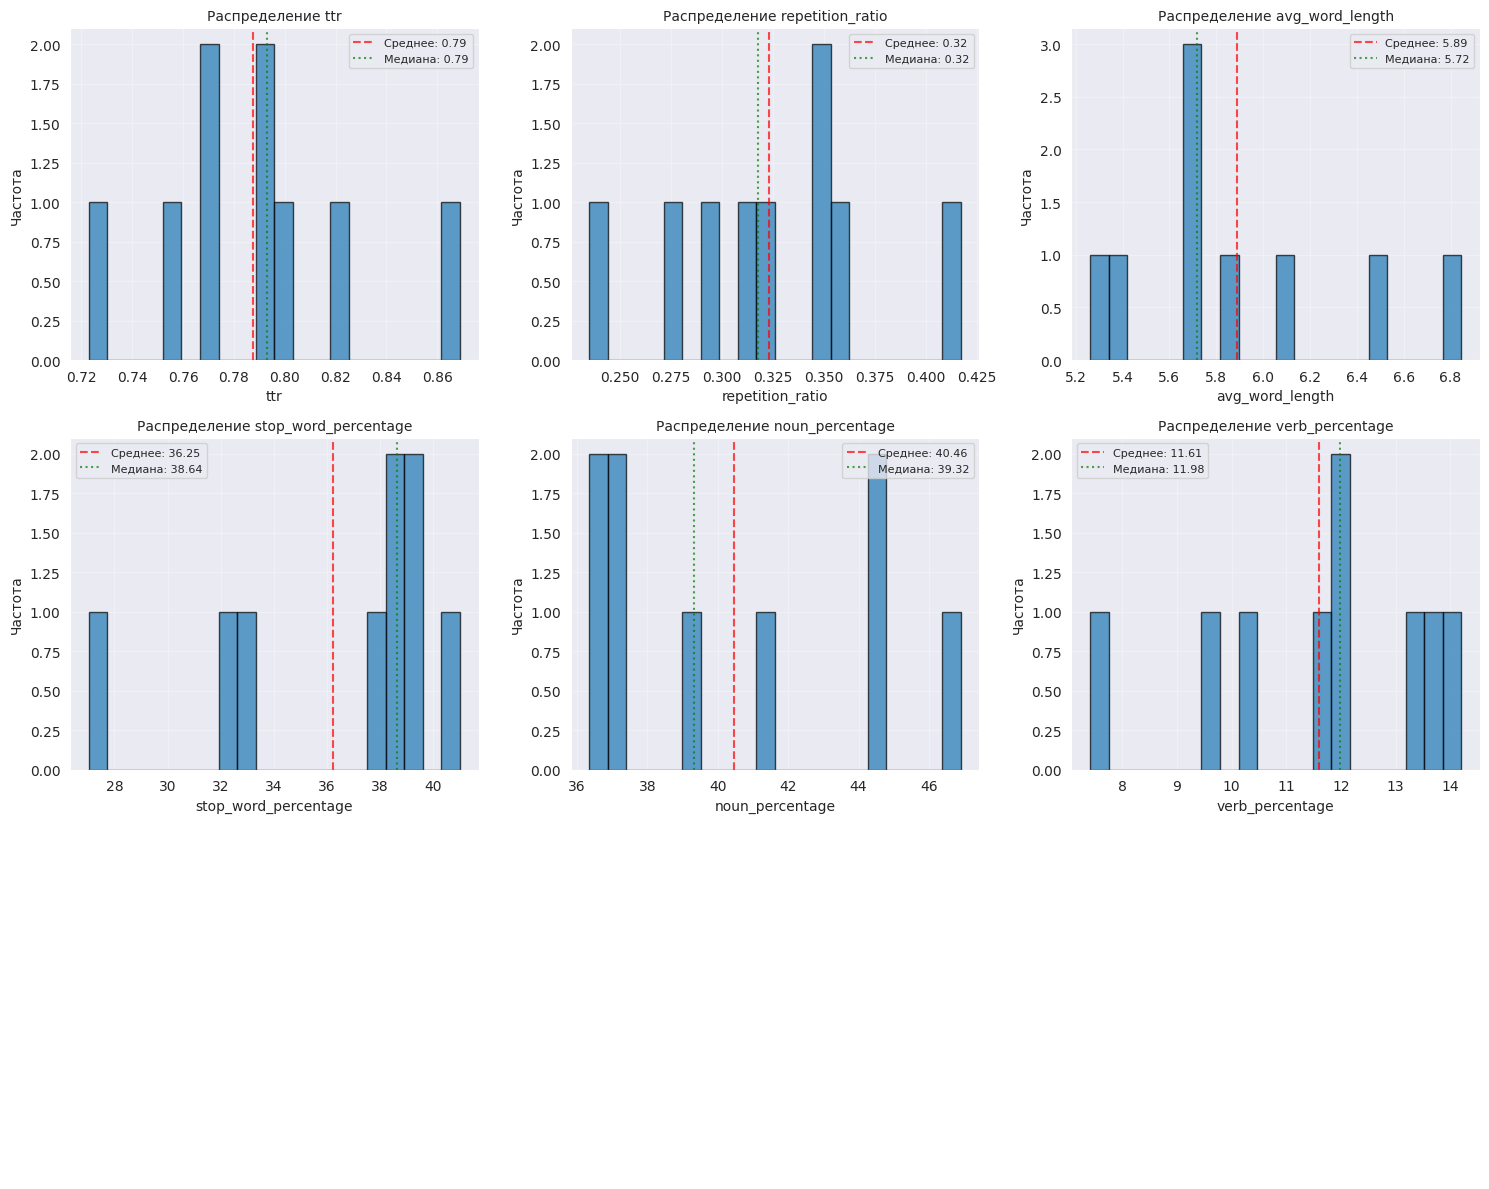


СТАТИСТИКА ПО NLP-МЕТРИКАМ:
        ttr  repetition_ratio  avg_word_length  stop_word_percentage  \
count  9.00              9.00             9.00                  9.00   
mean   0.79              0.32             5.89                 36.25   
std    0.04              0.05             0.51                  4.62   
min    0.72              0.23             5.26                 27.03   
25%    0.77              0.29             5.70                 32.72   
50%    0.79              0.32             5.72                 38.64   
75%    0.80              0.35             6.06                 39.24   
max    0.87              0.42             6.85                 41.02   

       noun_percentage  verb_percentage  
count             9.00             9.00  
mean             40.46            11.61  
std               4.05             2.16  
min              36.35             7.41  
25%              37.09            10.45  
50%              39.32            11.98  
75%              44.44      

In [13]:
def calculate_nlp_metrics(df):
    """
    Расчет NLP-метрик качества текста
    """
    print("=" * 50)
    print("NLP-МЕТРИКИ КАЧЕСТВА ТЕКСТА")
    print("=" * 50)

    if df.empty:
        print("Нет данных для расчета метрик")
        return pd.DataFrame()

    metrics_data = []

    for idx, row in df.iterrows():
        text = row['text']

        # Пропускаем слишком короткие тексты
        if len(text.split()) < 50:
            continue

        # Определяем язык для выбора соответствующей модели
        try:
            lang = detect(text[:500])
        except:
            lang = "en"  # по умолчанию английский

        # Выбираем модель spaCy в зависимости от языка
        nlp_model = nlp_ru if lang == 'ru' else nlp_en

        # Обработка текста через spaCy
        doc = nlp_model(text[:10000])  # Ограничиваем для скорости

        # 1. Readability scores (только для английского текста)
        readability_scores = {}
        if lang == 'en':
            try:
                readability_scores['flesch_reading_ease'] = textstat.flesch_reading_ease(text[:1000])
                readability_scores['flesch_kincaid_grade'] = textstat.flesch_kincaid_grade(text[:1000])
                readability_scores['smog_index'] = textstat.smog_index(text[:1000])
            except:
                readability_scores = {k: np.nan for k in ['flesch_reading_ease', 'flesch_kincaid_grade', 'smog_index']}
        else:
            readability_scores = {k: np.nan for k in ['flesch_reading_ease', 'flesch_kincaid_grade', 'smog_index']}

        # 2. Lexical diversity (Type-Token Ratio)
        words = [token.text.lower() for token in doc if token.is_alpha and not token.is_stop]
        if len(words) > 0:
            ttr = len(set(words)) / len(words)
        else:
            ttr = np.nan

        # 4. Text cohesion
        # Подсчет уникальных лемм
        lemmas = [token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop]
        unique_lemmas = set(lemmas)

        # Коэффициент лексического повторения
        if len(lemmas) > 0:
            repetition_ratio = 1 - (len(unique_lemmas) / len(lemmas))
        else:
            repetition_ratio = np.nan

        # 5. Дополнительные метрики
        # Средняя длина слова
        word_lengths = [len(token.text) for token in doc if token.is_alpha]
        avg_word_length = np.mean(word_lengths) if word_lengths else np.nan

        # Процент стоп-слов
        total_words = len([token for token in doc if token.is_alpha])
        stop_words_count = len([token for token in doc if token.is_stop])
        stop_word_percentage = (stop_words_count / total_words * 100) if total_words > 0 else np.nan

        # Процент существительных
        nouns = len([token for token in doc if token.pos_ in ['NOUN', 'PROPN']])
        noun_percentage = (nouns / total_words * 100) if total_words > 0 else np.nan

        # Процент глаголов
        verbs = len([token for token in doc if token.pos_ == 'VERB'])
        verb_percentage = (verbs / total_words * 100) if total_words > 0 else np.nan

        metrics_data.append({
            'filename': row['filename'],
            'language': lang,
            'ttr': ttr,
            'repetition_ratio': repetition_ratio,
            'avg_word_length': avg_word_length,
            'stop_word_percentage': stop_word_percentage,
            'noun_percentage': noun_percentage,
            'verb_percentage': verb_percentage,
        })

    metrics_df = pd.DataFrame(metrics_data)

    # Визуализация метрик
    if not metrics_df.empty:
        # Отбираем только числовые колонки для визуализации
        numeric_cols = metrics_df.select_dtypes(include=[np.number]).columns.tolist()

        # Создаем графики
        fig, axes = plt.subplots(3, 3, figsize=(15, 12))
        axes = axes.flatten()

        for i, col in enumerate(numeric_cols[:9]):  # Первые 9 числовых колонок
            ax = axes[i]
            ax.hist(metrics_df[col].dropna(), bins=20, edgecolor='black', alpha=0.7)
            ax.set_title(f'Распределение {col}', fontsize=10)
            ax.set_xlabel(col)
            ax.set_ylabel('Частота')
            ax.grid(True, alpha=0.3)

            # Добавляем статистику
            mean_val = metrics_df[col].mean()
            median_val = metrics_df[col].median()
            ax.axvline(mean_val, color='red', linestyle='--', alpha=0.7, label=f'Среднее: {mean_val:.2f}')
            ax.axvline(median_val, color='green', linestyle=':', alpha=0.7, label=f'Медиана: {median_val:.2f}')
            ax.legend(fontsize=8)

        # Убираем лишние оси, если колонок меньше 9
        for i in range(len(numeric_cols), 9):
            axes[i].axis('off')

        plt.tight_layout()
        plt.show()

        # Вывод статистики по метрикам
        print("\nСТАТИСТИКА ПО NLP-МЕТРИКАМ:")
        print(metrics_df[numeric_cols].describe().round(2))

        # Интерпретация метрик
        print("\nИНТЕРПРЕТАЦИЯ МЕТРИК:")
        print(f"1. Type-Token Ratio (TTR):")
        print(f"   Среднее: {metrics_df['ttr'].mean():.3f}")
        print(f"   Высокий TTR (>0.7) указывает на богатый словарный запас")

        print(f"\n3. Лексические повторения:")
        print(f"   Коэффициент повторений: {metrics_df['repetition_ratio'].mean():.3f}")
        print(f"   Высокие значения (>0.3) могут указывать на недостаточное разнообразие лексики")

        print(f"\n4. Состав текста:")
        print(f"   Существительные: {metrics_df['noun_percentage'].mean():.1f}%")
        print(f"   Глаголы: {metrics_df['verb_percentage'].mean():.1f}%")
        print(f"   Стоп-слова: {metrics_df['stop_word_percentage'].mean():.1f}%")

        if 'flesch_kincaid_grade' in metrics_df.columns:
            print(f"\n5. Readability (Flesch-Kincaid Grade Level):")
            print(f"   Среднее: {metrics_df['flesch_kincaid_grade'].mean():.1f}")
            print(f"   11-14 - уровень старшей школы/первых курсов университета")

    return metrics_df

# Расчет NLP-метрик
metrics_df = calculate_nlp_metrics(df)